In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

Importing and processing the USG and ground-based comparison data `csv`, which we use to compute our KDE for speed and radiant uncertainty:

In [2]:
usg_ground_based_comparison = pd.read_csv('usg-ground-based-comparison/usg-ground-based-comparison_EDITED.csv', sep = ',', skip_blank_lines=True).iloc[2:-3]  
# skip the first two rows after header and the last three rows since those are garbage

# forward fill Event and radiant, backward fill dv based on the xlsx file
usg_ground_based_comparison['Event'] = usg_ground_based_comparison['Event'].fillna(method='ffill')
usg_ground_based_comparison['Radiant Diff'] = usg_ground_based_comparison['Radiant Diff'].fillna(method='ffill')
usg_ground_based_comparison['DV'] = usg_ground_based_comparison['DV'].fillna(method='bfill')

# drop every other row since we don't need duplicate rows for event, radiant diff, or dv
# however we want to keep the usg reported speed, zenith angle and other parameters (second row for each event), 
# so we start by dropping the first row rather than the second
usg_ground_based_comparison = usg_ground_based_comparison.iloc[1::2]
# strip whitespace from headers to avoid errors with indexing later
usg_ground_based_comparison.columns = usg_ground_based_comparison.columns.str.strip()
# sort dataframe alphabetically
usg_ground_based_comparison.sort_values('Event', inplace=True)

Get the speed and radiant uncertainties:

In [3]:
# convert Speed, DV, Radiant Diff, Radiant Zenith Angle, Height, Begin Height, End Height, Length to numeric to avoid errors
cols_to_convert = ['Speed', 'DV', 'Radiant Diff', 'Radiant Zenith Angle', 'Height', 'Begin Height (km)', 'End Height (km)', 'Length (km)']
usg_ground_based_comparison[cols_to_convert] = usg_ground_based_comparison[cols_to_convert].apply(pd.to_numeric, errors='coerce', axis=1)

# convert date to datetime object
usg_ground_based_comparison['Date'] = pd.to_datetime(usg_ground_based_comparison['Date'])

# usg speed, dv, drad
usg_speed = usg_ground_based_comparison['Speed']
# speed and radiant uncertainties
dv = usg_ground_based_comparison['DV']
drad = usg_ground_based_comparison['Radiant Diff']

Construct the KDEs for speed and log-radiant uncertainty:

Speed uncertainty:

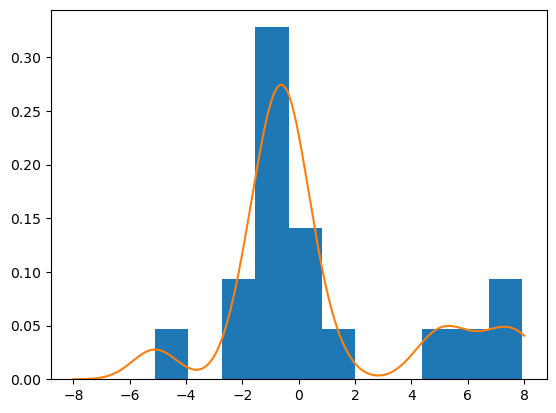

In [4]:
# parameters for fitting the KDE
dv_ub = 8.  # upper bound for fitting kde
dv_lb = -8.  # lower bound for fitting kde
dv_bandwidth = 0.8  # this is finicky
kernel_type = 'gaussian'

# setting up the values
values_dv = np.linspace(dv_lb, dv_ub, int(1e4))
kde_dv = np.array(dv).reshape((len(dv), 1))
kde_values_dv = values_dv.reshape(len(values_dv), 1)

# doing the KDE fit
kde_model_dv = KernelDensity(bandwidth=dv_bandwidth, kernel=kernel_type)
kde_model_dv.fit(kde_dv)

# plotting the KDE
plt.hist(dv, density=True, bins='auto')
plt.plot(kde_values_dv, np.exp(kde_model_dv.score_samples(kde_values_dv)))

Log-radiant uncertainty:

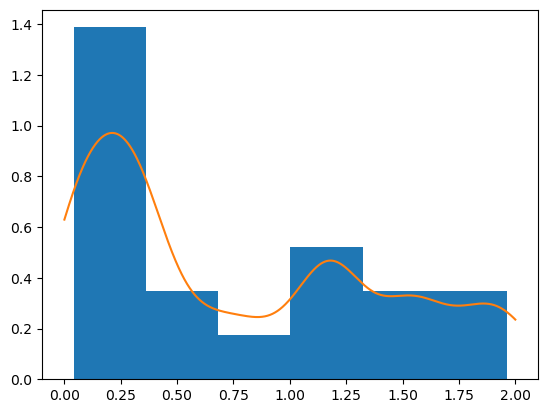

In [5]:
# parameters for the KDE fitting
drad_lb = 0.  # upper bound for fitting kde
drad_ub = 2.  # lower bound for fitting kde
log_drad_bandwidth = 0.15  # this is finicky

# setting up the values
log_drad = np.log10(drad)  # convert to log
values_drad = np.linspace(drad_lb, drad_ub, int(1e4))
kde_log_drad = np.array(log_drad).reshape((len(log_drad), 1))
kde_values_log_drad = values_drad.reshape(len(values_drad), 1)

# kde fit
kde_model_log_drad = KernelDensity(bandwidth=log_drad_bandwidth, kernel=kernel_type)
kde_model_log_drad.fit(kde_log_drad)

# plot
plt.hist(log_drad, density=True, bins='auto')
plt.plot(kde_values_log_drad, np.exp(kde_model_log_drad.score_samples(kde_values_log_drad)))

Reading in the `.dat` file for the Granvik model -- **get these from the dropbox if you want to use locally!**

In [6]:
# defining the granvik columns (could figure out how to get pandas to read this automatically in the dat file that actually has headers
granvik_columns = ['sma', 'ecc', 'inc', 'Hmag', 'number', 'rel_dnumber', 
                   'nu6_prob', '5/2_prob', '2/1_prob', 'HUN_prob', '3/1_prob', 'PHO_prob', 'JFC_prob', 
                   'nu6_sigma', '5/2_sigma', '2/1_sigma', 'HUN_sigma', '3/1_prob', 'PHO_sigma', 'JFC_sigma', 
                   'pv<0.1', '0.1<pv<0.3', 'sig', 'albedo_cat', 'collprob', 'MOID']

# read in the granvik file
granvik_model = pd.read_csv('granvik-model/gmb_model-noheader.dat', delim_whitespace=True, skip_blank_lines=True, header=None, float_precision='high')
granvik_model.columns = granvik_columns  # columns

Reading in the `.csv` file containing the decameter impactors:

In [7]:
# we define decameter impactors to be between 7.5 and 25 meters in diameter
# range of sizes (diameter in meters) we consider to be in the decameter regime
decameter_lb = 7.5  # lower bound
decameter_ub = 25.  # upper bound

# read file containing all impactors, no need to define columns since pandas reads this fine
all_impactors = pd.read_csv('../JPL-website-Oct19-2022-ORBITS-radiants-wspeeds-decameter-impactors-GOOD (1).csv', header='infer')
# filtering to only include those of decameter size (diameter is within some size range)
decameter_impactors = all_impactors.loc[(decameter_lb < all_impactors['Diameter (rho = 1500 kgm-3)']) & 
                                        (all_impactors['Diameter (rho = 1500 kgm-3)'] < decameter_ub)]
# convert time to datetime format
decameter_impactors['Time'] = pd.to_datetime(decameter_impactors['Time'])
# convert every column other than time to numeric
decameter_impactors[decameter_impactors.columns[decameter_impactors.columns != 'Time']] = decameter_impactors[decameter_impactors.columns[decameter_impactors.columns != 'Time']].apply(pd.to_numeric, errors='coerce', axis=1)

/tmp/ipykernel_2550951/2348476191.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decameter_impactors['Time'] = pd.to_datetime(decameter_impactors['Time'])
/tmp/ipykernel_2550951/2348476191.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decameter_impactors[decameter_impactors.columns[decameter_impactors.columns != 'Time']] = decameter_impactors[decameter_impactors.columns[decameter_impactors.columns != 'Time']].apply(pd.to_numeric, errors='coerce', axis=1)


Now we want to convert the state vectors for the $100$ Monte Carlo samples of each decameter impact event. We first take $100$ Monte Carlo samples using the KDEs defined earlier. The state vectors we use are:
- Velocity
- Time of observation
- Latitude
- Longitude
- Elevation
- Azimuth
- Altitude
  
with random velocity errors added that we draw from our KDE for the velocity uncertainty earlier. The state vectors are then converted 
into orbital elements $\left(a, e, i, \Omega, \omega, M\right)$ (semi-major axis, eccentricity, inclination, longitude of ascending node, argument of pericenter, mean anomaly)  using `WMPL`.


**TODO**: figure out how to implement the `drad` uncertainty (since the radiant uncertainty is dependent on both the altitude and the azimuth, so see how `drad` breaks down into individual uncertainties for altitude and azimuth):

First get the state vectors for all the events:

In [8]:
# state vectors
state_vector_list = ['Speed', 'Time', 'Latitude Numerical', 'Longitude Numerical', 'Altitude(km)', 'Zenith Distance', 'Radiant azimuth']
# drops the 1994 event right now as it doesn't have a lot of the information, and reset the index
impactor_state_vectors = decameter_impactors[state_vector_list].dropna().reset_index(drop=True)
# convert time to the format that wmpl takes in, '%Y%m%d-%H%M%S.%f'
impactor_state_vectors['Time'] = impactor_state_vectors['Time'].dt.strftime('%Y%m%d-%H%M%S.%f')

Then for each event, get $100$ Monte Carlo samples, compute the orbital parameters for each Monte Carlo samples, and save it to an array:

Defining the `get_orbital_parameters` function to be used for computing orbital parameters from the state vector parameters:

In [9]:
def get_orbital_parameters(state_vector_params, orb_param_variables=['a', 'e', 'i', 'peri', 'node', 'M']):
    """
    Gets the orbital parameter values corresponding to each parameter in orb_param_variables from the state vector state_vector

    param state_vector_params: tuple of (dv, v, t, a, o, e, azim, alt):
    dv is the velocity uncertainty to be added to the velocity vector
    v is the velocity
    t is the time of the event
    a is the latitude
    o is the longitude
    e is the elevation of the event
    azim is the radiant azimuth
    zen is the zenith distance (90 minus the altitude angle)

    returns a 1-D array of parameter values corresponding to the parameters in orb_param_variables, in the same order
    """
    dv, v, t, a, o, e, azim, zen = state_vector_params  # get the state vector parameters
    # converting from zenith angle to altitude angle
    alt = 90 - zen
    # get the output from the wmpl.Trajectory.Orbit file, adding the uncertainty in velocity to the velocity vector of the event
    output = subprocess.run(['python3', '-m', 'wmpl.Trajectory.Orbit', '-v', f'{v + dv}', '-t', f'{t}', '-a', f'{a}', '-o', f'{o}', '-e', f'{e}', 
            '--azim', f'{azim}', '--alt', f'{alt}', '--vrotcorr', '--statfixed'], capture_output=True)
    # get the orbital parameters in the order of orb_param_variables
    
    # orb_param_list = [elem for elem in list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
    #               if elem.startswith(tuple(orb_param_variables))]
    # orb_param_array = [np.float64(string) for param in orb_param_list 
    #                    for string in param.split() if string.lstrip('-').replace('.', '').isdigit() or string =='nan']]
    
    orb_param_array = np.array([np.float64(string) for param in [elem for elem in 
                                                                 list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
                                                                 if elem.startswith(tuple(orb_param_variables))] 
                                for string in param.split() if string.lstrip('-').replace('.', '').isdigit() or string =='nan'])
    
    #### ADD THIS AS A SAFEGUARD BECAUSE IT SEEMS LIKE SOMETIMES WMPL DOESN'T RETURN THE ORBITAL ELEMENTS AT ALL

    # if empty, return an array with the right size with all nans...
    # this is the safeguard for now
    if not orb_param_array.size:
        orb_param_array = np.repeat(np.nan, len(orb_param_variables))
    
    # return the orbital parameter array
    return orb_param_array

Optional: Computing orbital parameters from state vector parameters using multiprocessing -- skip this cell if already have the orbital parameters saved as a `.npy` or something

In [10]:
from tqdm import tqdm
import multiprocessing
import subprocess

# list of orbital parameters we want to get (named the same as in the wmpl output, in that order
orb_param_variables = ['a', 'e', 'i', 'peri', 'node', 'M']  
# number of Monte Carlo samples for each event
n_monte_carlo_samples = 100

# initialize array for orbital parameters for all the events with the shape 
# (number of impact events, number of monte carlo samples per event, number of orbital parameters per monte carlo sample)
orb_param_array_all_events = np.zeros((len(impactor_state_vectors), n_monte_carlo_samples, len(orb_param_variables)))

# compute orbital parameters of Monte Carlo samples for each event in the decameter impactors table
for i, event in impactor_state_vectors.iterrows():
    # perform the Monte Carlo sampling and flatten the array
    dv_samples = kde_model_dv.sample(n_samples=n_monte_carlo_samples).flatten()
    
    # get the state vectors to input into the wmpl.Trajectory.Orbit file
    v = event['Speed']
    t = event['Time']
    a = event['Latitude Numerical']
    o = event['Longitude Numerical']
    e = event['Altitude(km)']
    azim = event['Radiant azimuth']
    # zenith distance, note that altitude is 90 minus the zenith distance! 
    zen = event['Zenith Distance']  # this is converted to alt in the get_orbital_parameters function

    # create parameter list for multiprocessing
    state_vector_par_list = []
    # use different dv for each set of parameters
    for dv in dv_samples:
        state_vector_params = (dv, v, t, a, o, e, azim, zen)
        state_vector_par_list.append(state_vector_params)
    
    # now compute the orbital parameters from the state vectors for each Monte Carlo sample, using multiprocessing:
    pool = multiprocessing.Pool(multiprocessing.cpu_count() - 1)  # avoids locking up the CPU by using every core
    # get the array of orbital parameters for all the monte carlo samples of this single event, using multiprocessing
    orb_param_array_single_event = np.asarray(list(tqdm(pool.imap(get_orbital_parameters, state_vector_par_list))))
    # add the orb param array for this single event to the orbital parameter array for all events
    orb_param_array_all_events[i] = orb_param_array_single_event

100it [00:39,  2.54it/s]
100it [00:35,  2.80it/s]
100it [00:37,  2.63it/s]
100it [00:35,  2.81it/s]
100it [00:35,  2.78it/s]
100it [00:36,  2.77it/s]
100it [00:37,  2.67it/s]
100it [00:36,  2.72it/s]
100it [00:38,  2.60it/s]
100it [00:35,  2.79it/s]
100it [00:36,  2.78it/s]


Optional: Save the file as a numpy array (although it doesn't take too long to run, something like ~7 minutes to run with multiprocessing on my office workstation)

In [11]:
np.save('orb_params_all_events_mc.npy', orb_param_array_all_events)  # save as a .npy file

Optional: Read in `.npy` file for all the orbital parameters if haven't already run the multiprocessing code:

In [12]:
# orb_param_array_all_events = np.load('orb_params_all_events_mc.npy')  # get the orbital parameters

Plotting distribution of semi-major axis for these events vs. the "true" value as a test to see if the pipeline is working as we expect:

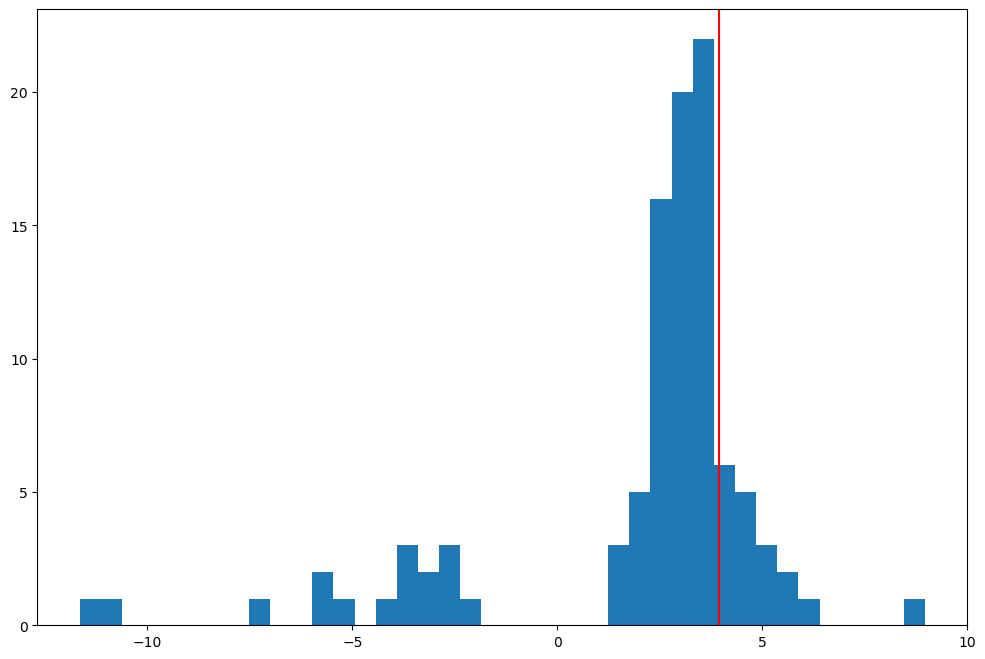

(3.9405809, 3.0881610000000004)

In [13]:
# get "true" semi-major axes from the sheet
true_smas = decameter_impactors['a'].dropna().reset_index(drop=True)
# get mc'ed semi-major axes
event_ind = 1  # event to check

# filter outliers to make the histogram a bit easier to see
filtered_array = orb_param_array_all_events[event_ind, :, 0][(orb_param_array_all_events[event_ind, :, 0] 
                                                              < 20) & (orb_param_array_all_events[event_ind, :, 0] 
                                                                       > -20)]

# plot everything
plt.figure(figsize = (12, 8))
# plot distribution of semi-major axis for all the Monte Carlo clones compared to the "true" value
plt.hist(filtered_array, bins='auto')  # plot histogram
# plot true value
plt.axvline(true_smas[event_ind], c='r')
plt.show()
true_smas[event_ind], np.median(filtered_array)

**TODO**: Interpolate the Granvik file for the $a$, $e$, $i$ values to get intermediate values for the whole parameter space and then run the list of Monte Carlo'd orbital parameters through it for each event to get the escape region probabilities for every event:

#### Testing/Debugging:

**NOTE**: sometimes wmpl.Trajectory.Orbit doesn't return the orbital elements? for example the command `python3 -m wmpl.Trajectory.Orbit -v 9.542999528129108 -t '20130430-084000.000000' -a 35.5 -o -30.7 -e 21.2 --azim 297.7709815 --alt 39.50375116 --vrotcorr --statfixed` doesn't return orbital elements

should mention this to peter at some point...

Debugging for individual state vector-to-orbital element computations:

In [389]:
state_vector_index = 0

dv, v, t, a, o, e, azim, zen = state_vector_par_list[state_vector_index]
alt = 90 - zen

output = subprocess.run(['python3', '-m', 'wmpl.Trajectory.Orbit', '-v', f'{v + dv}', '-t', f'{t}', '-a', f'{a}', '-o', f'{o}', '-e', f'{e}', 
            '--azim', f'{azim}', '--alt', f'{alt}', '--vrotcorr', '--statfixed'], capture_output=True)
# [elem for elem in list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) if elem.startswith(tuple(orb_param_variables))]

In [397]:
test = np.array([np.float64(string) for param in [elem for elem in list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
                                           if elem.startswith(tuple(orb_param_variables))] 
          for string in param.split() if string.lstrip('-').replace('.', '').isdigit() or string =='nan'])

In [404]:
if not test.size:
    test = np.repeat('EMPTY', len(orb_param_variables))

In [403]:
test

array(['nan', 'nan', 'nan', 'nan', 'nan', 'nan'], dtype='<U3')

In [383]:
state_vector_par_list[0]

(-2.5400464418708926,
 12.08304597,
 '20130430-084000.000000',
 35.5,
 -30.7,
 21.2,
 297.7709815,
 50.49624884)

In [393]:
90 - 50.49624884

39.50375116

In [392]:
12.08304597 -2.5400464418708926

9.542999528129108

In [406]:
pool = multiprocessing.Pool(multiprocessing.cpu_count() - 1)  # avoids locking up the CPU by using every core
orb_param_list = list(tqdm(pool.imap(get_orbital_parameters, state_vector_par_list)))

100it [00:47,  2.09it/s]


In [410]:
np.array(orb_param_list)

array([['EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY'],
       ['1.232723', '0.29763', '26.194823', '247.195346', '39.988546',
        '321.355526'],
       ['1.280359', '0.324662', '28.190314', '245.025289', '39.988067',
        '325.081691'],
       ['EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY'],
       ['EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY'],
       ['1.231219', '0.296727', '26.124221', '247.269521', '39.988564',
        '321.22605'],
       ['1.073169', '0.137438', '9.352036', '250.774353', '40.000129',
        '303.550915'],
       ['EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY'],
       ['1.061505', '0.098209', '5.351', '243.614369', '40.013332',
        '306.106139'],
       ['1.050937', '0.070749', '3.274978', '237.416087', '40.032831',
        '309.174587'],
       ['1.04364', '0.055506', '2.380265', '233.663934', '40.051703',
        '311.270064'],
       ['1.238909', '0.301311', '26.479751', '246.893961', '39.988474',
        '321.879925']

Test if the multiprocessing is working

In [328]:
def get_orbital_parameters(state_vector_params, orb_param_variables=['a', 'e', 'i', 'peri', 'node', 'M']):
    """
    Gets the orbital parameter values corresponding to each parameter in orb_param_variables from the state vector state_vector

    param state_vector_params: tuple of (dv, v, t, a, o, e, azim, alt):
    dv is the velocity uncertainty to be added to the velocity vector
    v is the velocity
    t is the time of the event
    a is the latitude
    o is the longitude
    e is the elevation of the event
    azim is the radiant azimuth
    zen is the zenith distance (90 minus the altitude angle)

    returns a 1-D array of parameter values corresponding to the parameters in orb_param_variables, in the same order
    """
    dv, v, t, a, o, e, azim, zen = state_vector_params  # get the state vector parameters
    # converting from zenith angle to altitude angle
    alt = 90 - zen
    # get the output from the wmpl.Trajectory.Orbit file, adding the uncertainty in velocity to the velocity vector of the event
    output = subprocess.run(['python3', '-m', 'wmpl.Trajectory.Orbit', '-v', f'{v + dv}', '-t', f'{t}', '-a', f'{a}', '-o', f'{o}', '-e', f'{e}', 
            '--azim', f'{azim}', '--alt', f'{alt}', '--vrotcorr', '--statfixed'], capture_output=True)
    # get the orbital parameters in the order of orb_param_variables
    
    # orb_param_list = [elem for elem in list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
    #               if elem.startswith(tuple(orb_param_variables))]
    # orb_param_array = [np.float64(string) for param in orb_param_list for string in param.split() if string.replace('.', '').isdigit()]
    
    orb_param_array = np.array([np.float64(string) for param in [elem for elem in 
                                                             list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
                                                             if elem.startswith(tuple(orb_param_variables))] 
                            for string in param.split() if string.lstrip('-').replace('.', '').isdigit() or string =='nan'])
    # return the orbital parameter array
    return orb_param_array

In [329]:
# chelyabinsk params

v = 18.61424186
t = "20130215-032033.0"
a = 54.8
o = 61.1
e = 23.3
azim = 99.8959271
zen = 74.07574403

from tqdm import tqdm
import subprocess

# list of orbital parameters we want to get (named the same as in the wmpl output, in that order
orb_param_variables = ['a', 'e', 'i', 'peri', 'node', 'M']  
# monte carlo
n_monte_carlo_samples = 100
dv_samples = kde_model_dv.sample(n_samples=n_monte_carlo_samples).flatten()

# create parameter list for multiprocessing
state_vector_par_list = []
# use different dv for each set of parameters
for dv in dv_samples:
    state_vector_params = (dv, v, t, a, o, e, azim, zen)
    state_vector_par_list.append(state_vector_params)

In [335]:
import multiprocessing

pool = multiprocessing.Pool(multiprocessing.cpu_count() - 1)  # avoids locking up the CPU by using every core
orb_param_array = list(tqdm(pool.imap(get_orbital_parameters, state_vector_par_list)))

100it [00:38,  2.60it/s]


Distribution of semi-major axis for all the Monte Carlo clones compared to the true value for chelyabinsk

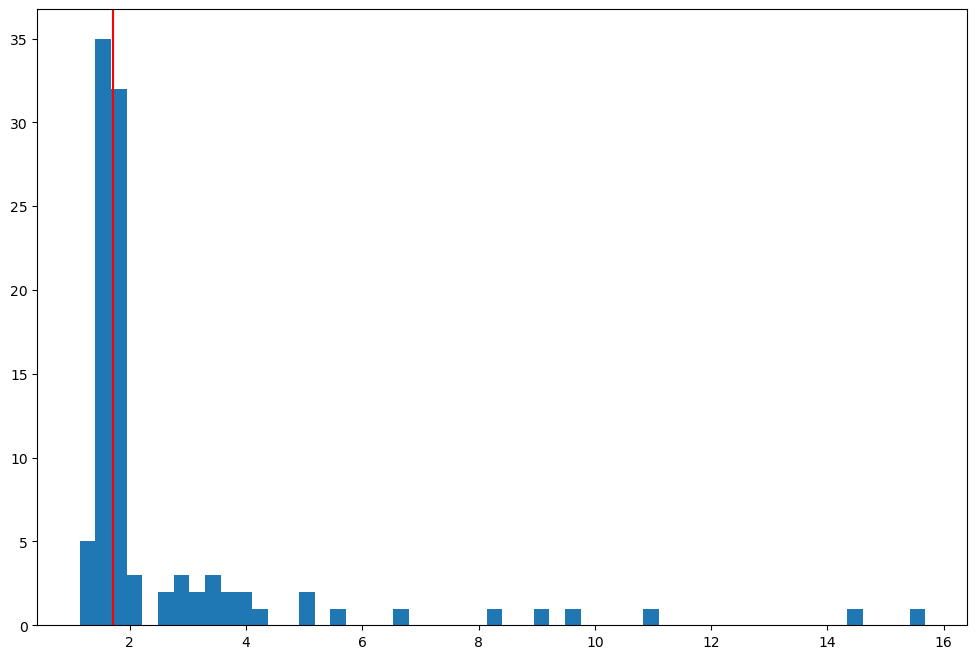

In [336]:
plt.figure(figsize = (12, 8))
# plot distribution of semi-major axis for all the Monte Carlo clones compard to "true" value for chelyabinsk
plt.hist(np.array(orb_param_array)[:,0], bins='fd')
plt.axvline(1.713518, c='r')

Getting orbital parameters from state vectors test:

In [283]:
chelyabinsk = impactor_state_vectors.iloc[0]

# chelyabinsk params

v = 18.61424186
t = "20130215-032033.0"
a = 54.8
o = 61.1
e = 23.3
azim = 99.8959271
alt = 15.924256

from tqdm import tqdm
import subprocess

# list of orbital parameters we want to get (named the same as in the wmpl output, in that order
orb_param_variables = ['a', 'e', 'i', 'peri', 'node', 'M']  
# initialize empty array to hold all the orbital parameters
orb_param_array = np.zeros((n_monte_carlo_samples, len(orb_param_variables)))

# convert the monte carlo'd state vectors to orbital parameters
for i, dv in tqdm(enumerate(dv_samples)):
    # get the output from the wmpl.Trajectory.Orbit file, adding the uncertainty in speed to the velocity vector of the event
    output = subprocess.run(['python3', '-m', 'wmpl.Trajectory.Orbit', '-v', f'{v + dv}', '-t', f'{t}', '-a', f'{a}', '-o', f'{o}', '-e', f'{e}', 
                '--azim', f'{azim}', '--alt', f'{alt}', '--vrotcorr', '--statfixed'], capture_output=True)
    # get the orbital parameters in the order of orb_param_variables
    
    # orb_param_list = [elem for elem in list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
    #               if elem.startswith(tuple(orb_param_variables))]
    # orb_param_array[i] = [np.float64(string) for param in orb_param_list for string in param.split() if string.replace('.', '').isdigit()]
    
    orb_param_array[i] = np.array([np.float64(string) for param in [elem for elem in 
                                                             list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
                                                             if elem.startswith(tuple(orb_param_variables))] 
                            for string in param.split() if string.lstrip('-').replace('.', '').isdigit() or string =='nan'])

100it [04:34,  2.74s/it]


In [360]:
import subprocess 
# get the std output from the wmpl.Trajectory.Orbit file

v = 18.61424186
t = "20130215-032033.0"
a = 54.8
o = 61.1
e = 23.3
azim = 99.8959271
zen = 74.07574403

output = subprocess.run(['python3', '-m', 'wmpl.Trajectory.Orbit', '-v', f'{v}', '-t', f'{t}', '-a', f'{a}', '-o', f'{o}', '-e', f'{e}', 
                '--azim', f'{azim}', '--alt', f'{90 - zen}', '--vrotcorr', '--statfixed'], capture_output=True)

# list of orbital parameters we want to get (named the same as in the wmpl output, in that order
orb_param_variables = ['a', 'e', 'i', 'peri', 'node', 'M']  
# get the orbital parameters a, e, i, peri, node, M from the output, in that order

# orb_param_list = [elem for elem in list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
#               if elem.startswith(tuple(orb_param_variables))]
# orb_params = [np.float64(string) for param in orb_param_list for string in param.split() if string.replace('.', '').isdigit()]

orb_param_array = np.array([np.float64(string) for param in [elem for elem in 
                                                             list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
                                                             if elem.startswith(tuple(orb_param_variables))] 
                            for string in param.split() if string.lstrip('-').replace('.', '').isdigit() or string =='nan'])

print(orb_param_array)

[  1.713518   0.560746   4.089321 109.703891 326.445236  19.892276]
